In [77]:
!cp -r /content/drive/MyDrive/Pose_Estimation_Paper/* /content/

In [72]:
!unzip -j /content/images.zip -d /content/images/ > /dev/null

replace /content/images/img1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [73]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as ROT

In [74]:
cam_mat = np.array([[711.111, 0, 256.0], [0, 711.111, 256.0], [0, 0, 1]])
keypts = np.array([
  [6.816, -0.013, 0.021],
  [5.956, -0.013, -3.356],
  [5.777, -1.405, -0.004],
  [5.777, 1.345, -0.004],
  [5.956, -0.013, 1.196],
  [3.661, -12.531, 0.097],
  [-0.306, -12.531, 0.097],
  [1.704, -1.753, 0.097],
  [1.704, 1.889, 0.097],
  [3.661, 12.542, 0.097],
  [-0.306, 12.537, 0.097],
  [-6.720, -0.013, 0.011],
  [-4.292, -0.013, 2.201],
  [-4.292, 1.575, -1.476],
  [-4.292, -1.625, -1.476],
  [-2.516, 0.093, -8.451],
  [0.456, 0.093, -8.451],
  [-1.127, 0.093, -1.775],
  [1.772, 0.025, -1.689],
  [1.919, 0.025, 1.776],
  [-1.596, 0.025, 1.547]
])

In [78]:
df = pd.read_csv('simple_dataset.txt')

In [79]:
df.head()

,Image,x,y,z,qw,qx,qy,qz
0,img1.jpg,0.733,-1.050,60.177,0.424,-0.329,0.838,-0.096
1,img2.jpg,-2.675,3.939,55.630,-0.094,-0.304,0.263,0.911
2,img3.jpg,-2.389,5.136,56.913,-0.056,-0.477,-0.852,0.209
3,img4.jpg,-2.446,-1.007,53.320,-0.706,-0.255,0.310,-0.584
4,img5.jpg,4.701,0.091,51.103,0.798,-0.505,-0.325,-0.046


In [136]:
N = len(df)
bx = np.zeros(N)
by = np.zeros(N)
bw = np.zeros(N)
bh = np.zeros(N)

margin = 10

for i in range(N):
  rot_mat = np.squeeze(ROT.from_quat(df.iloc[[i]][['qx','qy','qz','qw']].values).as_matrix())
  t_vec = np.squeeze(df.iloc[[i]][['x','y','z']].values)

  cam_frame_pts = np.dot(keypts, rot_mat.T) + t_vec
  img_pts = np.squeeze(cv2.projectPoints(cam_frame_pts, np.eye(3), np.zeros(3), cam_mat, np.zeros(5))[0])
  
  min_x = np.min(img_pts[:,0]) - margin
  min_y = np.min(img_pts[:,1]) - margin
  max_x = np.max(img_pts[:,0]) + margin
  max_y = np.max(img_pts[:,1]) + margin

  bbx = (min_x + max_x)/2
  bby = (min_y + max_y)/2
  bbw = max_x - min_x
  bbh = max_y - min_y

  bx[i] = bbx
  by[i] = bby
  bw[i] = bbw
  bh[i] = bbh

df['bx'] = bx
df['by'] = by
df['bw'] = bw
df['bh'] = bh

In [137]:
df.head()

,Image,x,y,z,qw,qx,qy,qz,bx,by,bw,bh
0,img1.jpg,0.733,-1.050,60.177,0.424,-0.329,0.838,-0.096,247.680616,240.004065,184.204553,278.976437
1,img2.jpg,-2.675,3.939,55.630,-0.094,-0.304,0.263,0.911,231.409574,316.186593,192.162597,323.934479
2,img3.jpg,-2.389,5.136,56.913,-0.056,-0.477,-0.852,0.209,222.530529,344.785139,307.732287,218.206248
3,img4.jpg,-2.446,-1.007,53.320,-0.706,-0.255,0.310,-0.584,222.464975,255.793595,349.354942,181.055533
4,img5.jpg,4.701,0.091,51.103,0.798,-0.505,-0.325,-0.046,354.442635,257.882250,234.341452,251.664828


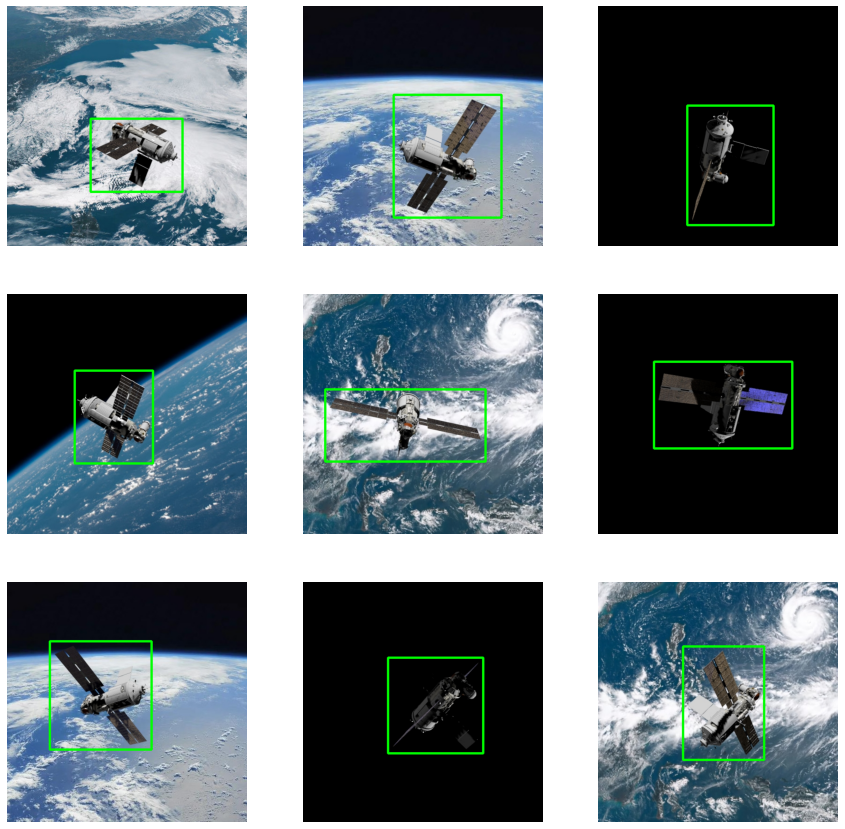

In [138]:
# load 9 random images and plot bounding box
fig, ax = plt.subplots(3,3, figsize=(15,15))

sample_n = 9
sample = df.sample(n=sample_n)

for i in range(sample_n):
  img = cv2.imread('/content/images/' + sample.iloc[i]['Image'])
  
  bbx = sample.iloc[i]['bx']
  bby = sample.iloc[i]['by']
  bbw = sample.iloc[i]['bw']
  bbh = sample.iloc[i]['bh']
  
  cv2.rectangle(img, (int(bbx-bbw/2), int(bby-bbh/2)), (int(bbx+bbw/2), int(bby+bbh/2)), (0, 255, 0), 3)
  
  ax[i//3][i%3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax[i//3][i%3].axis('off')

In [139]:
df.to_pickle('dataset.zip')

In [141]:
df = pd.read_pickle('dataset.zip')
df.head()

,Image,x,y,z,qw,qx,qy,qz,bx,by,bw,bh
0,img1.jpg,0.733,-1.050,60.177,0.424,-0.329,0.838,-0.096,247.680616,240.004065,184.204553,278.976437
1,img2.jpg,-2.675,3.939,55.630,-0.094,-0.304,0.263,0.911,231.409574,316.186593,192.162597,323.934479
2,img3.jpg,-2.389,5.136,56.913,-0.056,-0.477,-0.852,0.209,222.530529,344.785139,307.732287,218.206248
3,img4.jpg,-2.446,-1.007,53.320,-0.706,-0.255,0.310,-0.584,222.464975,255.793595,349.354942,181.055533
4,img5.jpg,4.701,0.091,51.103,0.798,-0.505,-0.325,-0.046,354.442635,257.882250,234.341452,251.664828
